# Debugging Neural Networks

In this notebook we'll take a look at some common issues encountered when building and training neural networks. As a lot of the code has been written for you, work slowly through the notebook, reading along the way - there are some important information!

## Data Normalisation

In this exercise we'll take a look at a form of [normalisation](https://en.wikipedia.org/wiki/Normalization_(statistics)) and how it can aide the training of neural networks (and other optimisation techniques, for that matter). As mentioned in the lectures, neural networks are most stable when the inputs and outputs have values near zero, with a standard deviation of approximately 1. Let's see what this looks like in practice.

We will demonstrate the importance of normalization using an interesting forecast prediction dataset. In this dataset we will use cartographic variables of small regions of forest (30m x 30m) to predict the type of forecast cover in each region. Example cover types include: spruce/fir (type 1), lodgepole pine (type 2), etc.

You can get more information about the data from this link.
https://archive.ics.uci.edu/ml/datasets/covertype

There is also a kaggle competition for this dataset:
https://www.kaggle.com/c/forest-cover-type-prediction/overview

According to the kaggle competition the best team got an accuracy of 100% on the test set! 


In [ ]:
# Quickly set up our device
import torch
import torch.nn as nn
import numpy as np
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
print("Training on", device)

Training on cuda:0


Here is the code we use to load the data into a pandas dataframe.

In [ ]:
import pandas as pd

# Read the data from csv file
cover_type_df = pd.read_csv('https://github.com/zhenhe1/datasets/raw/5852941fa9cd21326d3f7277d971e46e48ea2714/covtype_dataset.zip')


Lets take a look at the data using the next cell. Each row of the data contains the data for one small 30m x 30m region of the forest. You will notice the cartographic variables include things like elevation, aspect, slope, soil types etc. You will notice that the soil type values are much smaller than elevation, aspect, hydrology measurements. This is a sign that normalization is needed. The reason is it will be hard for the neural network to balance taking really big numbers and really small numbers at the same time. This will cause a lot of skew in the distribution of neural network weights. In addition neural networks just want to take small number as input and mean of around zero. Lets first try to train a network without normalization and then add normalization and see what happens.


In [ ]:
cover_type_df

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581007,2396,153,20,85,17,108,240,237,118,837,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581008,2391,152,19,67,12,95,240,237,119,845,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581009,2386,159,17,60,7,90,236,241,130,854,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
581010,2384,170,15,60,5,90,230,245,143,864,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


## Create a dataset class
In the next cell we will create a dataset class for our forest cover data. Notice this time the dataset class will directly take a pandas dataframe and then extract the input and labels from it. The data has 55 columns, the first 54 columns contain the cartographic variables used to predict forecast cover type. Notice we convert the data into numpy arrays instead of PyTorch tensors. It is fine for datasets to output numpy arrays since, once we wrap a dataloader around the dataset the dataloader will automatically convert the numpy arrays into PyTorch tensors.

You will need to do some work to complete the dataset class below.

In [ ]:
# Import the base class
from torch.utils.data import Dataset

# Subclassing in Python just requires adding the class name in parentheses
class CovDataset(Dataset):
    # The __init__ method is similar to a constructor like you find in other
    # languages. 
    def __init__(self, df):
        # We directly take the pandas data frame split the data into the inputs
        # and labels.
        # The first 54 columns contain the input attributes
        # The last column called Cover_type contain the data we want to predict
        self.inputs = df[df.columns[:54]].to_numpy().astype(np.float32)
        self.labels = df.Cover_Type.to_numpy().astype(np.long)
        # We make a deep copy of the inputs and store it as a copy of the original.
        # This way when we normalize the data in a future exercise we can make sure
        # we always apply the normalization based on the original inputs.
        self.original_inputs =  self.inputs.copy()

    def __len__(self):
        # TODO: Return the length (number of items) in the dataset
        # SOLUTION LINE
        return len(self.inputs)

    def __getitem__(self, idx):
        # TODO: Store the inputs and labels for the item at index idx in variables
        #       input and label
        # input = ...
        # label = ...
        
        # SOLUTION LINE
        input = self.inputs[idx]
        # SOLUTION LINE
        label = self.labels[idx]

        return input, label

    # TODO there will be instructions later for you to add a normalization
    #      function here. Remember you want to do the normalization from the
    #      original_inputs instead of inputs.

    # Solution
    def normalize_data(self, mean, std):
      self.inputs = ((self.original_inputs - mean)/std).astype(np.float32)



## Create train, validation and test dataset splits and dataloaders

The main difference is that we created a dataset class in the previous cell and passed the dataframe into it. So all the messy extraction of input data and labels are done in the dataset class. I think in general writing a dataset class is a more elegant way to code dataloading. So I encourage you to do that in the future as well.

You will notice the this dataset is quite large.

Please follow the instructions below to complete the code for creating the dataset object and then spliting it into train, validation and test splits. Then creating a *dataloader* for each dataset.



In [ ]:
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

# The percentages for each partition
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1
BATCH_SIZE = 64

# Ensure that the splits add to 100%
assert TRAIN_SPLIT + VAL_SPLIT + TEST_SPLIT == 1

# TODO : create the forecast cover dataset (CovDataset) object using the cover_type_df
#        dataframe.
# entirecoverDataSet = 

# Solution
entirecoverDataSet = CovDataset(cover_type_df)

# Calculate the number of examples in each partition
train_size = int(TRAIN_SPLIT * len(entirecoverDataSet))
val_size = int(VAL_SPLIT * len(entirecoverDataSet))
test_size = len(entirecoverDataSet) - train_size - val_size

print("Train examples:     ", train_size)
print("Validation examples:", val_size)
print("Test examples:      ", test_size)


#please use the random_split function to 
#     break entirecoverDataSet into train_dataset, val_dataset, test_dataset
# train_dataset, val_dataset, test_dataset = 

# Solution
train_dataset, val_dataset, test_dataset = random_split(entirecoverDataSet,
                                                      [train_size, val_size, test_size])




#TODO please create the train_loader, val_loader
#     and test_loader using their corresponding datasets.
#     Please do random shuffling for the train_loader, do not do random shuffle
#     for the other two data loaders

# train_loader =
# val_loader =
# test_loader = 

# Solution

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Train examples:      464809
Validation examples: 58101
Test examples:       58102


Lets take a look at the first element of the training dataset that we created. You should see a tuple where the first element contains a 1D array with 54 elements and the second element stores the output label.

In [ ]:
print(train_dataset[0])

(array([3.294e+03, 2.160e+02, 1.300e+01, 6.000e+01, 0.000e+00, 2.874e+03,
       2.070e+02, 2.520e+02, 1.790e+02, 7.890e+02, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00],
      dtype=float32), 1)


## MLP model

In the cell below finish the definition of a MLP model that will be used in the training loop. Notice we have already specified the default input and output size for the model. 

In [ ]:

# Custom models need to subclass nn.Module
class MLP(nn.Module):
    def __init__(self,
                 device,
                 input_size=54, # default to 54
                 output_size=8 # default to the number of classes
                 ):
        super().__init__()

        # Write the classifier layers here.
        self.seq = nn.Sequential(
            
            ## TODO: add the following layers
            #        Linear layer that outputs 64 neurons
            #        ReLU
            #        Linear layer that outputs 64 neurons
            #        ReLU
            #        Linear layer that outputs output_size neurons

            # Solution
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size),
        )
        # Transfer the model weights to the GPU
        self.to(device)
    
    # The forward method takes input values and returns predictions. We just need
    # to pass the inputs through the layers we defined in __init__
    def forward(self, x):
        return self.seq(x)

## Training loop
Note we are not using the validation dataset in order to keep the training code short. I have set the optimizer to the Adam optimizer with initial learning rate of 0.001.

Lets train the model and see what happens.

In [ ]:
def compute_accuracy(predictions, targets):
    # Find the index with the highest predicted value - this is the predicted digit
    predictions = predictions.argmax(1)
    # Count the number of predictions that match the target
    correct = (predictions == targets).sum().item()
    # Compute the accuracy as the percentage correctly predicted
    acc = correct / len(targets)
    return acc

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()
model = MLP(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# The number of times we loop over the entire dataset
total_epochs = 10
for epoch in tqdm(range(total_epochs)): 
    epoch_train_accuracy = []
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)   
        accuracy = compute_accuracy(outputs, labels)
        epoch_train_accuracy.append(accuracy)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('epoch: %d loss: %.3f' % (epoch + 1, running_loss / len(train_loader)))
    print('epoch: %d accuracy: %.3f' % (epoch + 1, np.mean(epoch_train_accuracy)))
print('Finished Training')


epoch: 1 loss: 0.903
epoch: 1 accuracy: 0.654
epoch: 2 loss: 0.657
epoch: 2 accuracy: 0.718
epoch: 3 loss: 0.614
epoch: 3 accuracy: 0.736
epoch: 4 loss: 0.589
epoch: 4 accuracy: 0.747
epoch: 5 loss: 0.574
epoch: 5 accuracy: 0.755
epoch: 6 loss: 0.562
epoch: 6 accuracy: 0.760
epoch: 7 loss: 0.552
epoch: 7 accuracy: 0.765
epoch: 8 loss: 0.543
epoch: 8 accuracy: 0.769
epoch: 9 loss: 0.538
epoch: 9 accuracy: 0.773
epoch: 10 loss: 0.532
epoch: 10 accuracy: 0.775

Finished Training


If everything goes according to plan you will notice that the training accuracy is around 77%. This is not that high considering other people can get 100% accuracy. Lets see what happens when we try it on the test dataset.

In [ ]:
running_loss = 0.0
total_test_accuracy = []

for i, data in enumerate(test_loader, 0):
   inputs, labels = data
   inputs, labels = inputs.to(device), labels.to(device)

   model.eval()
   with torch.no_grad():
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    accuracy = compute_accuracy(outputs, labels)
    total_test_accuracy.append(accuracy) 

print("test loss: ", running_loss/len(test_loader))
print('test accuracy: ', np.mean(total_test_accuracy))

test loss:  0.6161992052972054
test accuracy:  0.7343864720998532


## Normalizing the data
The test dataset also just reports accuracy of around 77%. Lets see if we can significantly improve the results using normalization.

The normalization we want to do is called the [Standard score](https://en.wikipedia.org/wiki/Standard_score#Calculation) or z-score. So you subtract the mean and divide by the standard deviation. So this means we need to compute the mean and standard deviation of every column of the data resulting in 54 means and 54 standard deviations. 

Doing this normalization to each column will make the values in each column have similar range of values and make them small and centered around zero. This will make the job of training the neural network much easier since the weights of the linear layer can have similar range of values since the input across the different input features have similar magnitudes.

The mean and standard deviation that we compute must be from the training dataset since in theory we do not have the statistics of the validation and test sets when training our model. Since the model is trained on the normalized data from the training set, it means when we perform validation and testing we also need to normalize the data based on the mean and standard deviation computed in the training dataset.

In the code below we first extract the numpy array containing the input data from the training dataset. It is up to you to write the code to compute the mean and standard deviation for each column of the data.

If you have done it correctly the data should be a 1D array with 54 elements.

We then call a normalize_data function on the entire dataset to normalize the train, validation and test datasets using the mean and standard deviation we just computed. We can do this by just normalizing the input data in the  <font color=red> entirecoverDataSet </font> object since all the other splits all use this dataset by just index different elements of it.

You need to go back to the <font color=red> CovDataset </font> class and add a function called <font color=red> normalize_data </font> which will normalize the input data member by subtracting the mean of the training data and dividing by the standard deviation. In the function please compute the normalized input based on the <font color=red original_inputs> instead of <font color=red inputs>. The reason for this is if you accidently call normalize twice, you don't want to the normalization to compound on each other. 

Once you have added the normalization function you will need to execute the "Create train, validation and test dataset splits and dataloaders" cell again to ensure the new updated definition of the <font color=red> CovDataset </font> class is used by the dataloaders. Then you will need to normalize the data by executing the next cell.

Once you have normalized the data, please go back to the training loop and execute it again. See how much higher the training and test accuracy goes. You should see a very significant increase in the accuracy (around 10% higher accuracy).

Feel free to come up with better models and also try different optimization parameter values to see if you can push the accuracy even higher.






In [ ]:
# Here we extract the input data of the training dataset into a
# numpy array called train_inputs.
train_inputs = entirecoverDataSet.inputs[train_dataset.indices]

# TODO : write code to extract the mean and standard deviation for each column 
#        of the data and store them in the following variables.
#        train_inputs_means = 
#        train_column_stds = 

# Solution 
train_inputs_means = train_inputs.mean(axis=0)
train_column_stds = train_inputs.std(axis=0)


# We call a normalize_data function on the entire data set.
# This normalizes all the input data for the train, validation and test splits
# in one go. 
# TODO: Please go to the CovDataset class and add a function called
#       normalize_data which normalizes the input by subtracting the mean
#       and dividing by the standard deviation from the original_input.
entirecoverDataSet.normalize_data(train_inputs_means, train_column_stds)


## Learning Rate Adjustments

In the past, we've mentioned the effects of a poor choice of learning rate, and we'll now look at a practical example.

To demonstrate this, we'll build a simple image dataset consisting of white squares and rectangles on a black background, with the task of classifying them as either squares or rectangles.

### Preparation

As before, the dataset has been implemented you. Feel free to read through it - although the implementation isn't particularly important.

Each example in the dataset consists of a white rectangle of a randomly chosen width and height, with a label of `1` if it's a square and `0` if it's a rectangle.

In [ ]:
from torch.utils.data import Dataset

class ToyImageDataset(Dataset):
    def __init__(self, num_examples):
        super().__init__()
        height, width = 12, 12
        self.images, self.labels = self.gen_examples(num_examples, height, width)

    def gen_examples(self, num_examples, height, width):
        # Rectangles can be at most half the width or height of the image
        max_height, max_width = height // 2, width // 2

        # Initialise a tensor of zeros to fill in with rectangles
        images = torch.zeros((num_examples, 1, height, width), dtype=torch.float32)

        # Randomly generate the top-left corner of each rectangle
        tops = torch.randint(0, height - 1, (num_examples,))
        lefts = torch.randint(0, width - 1, (num_examples,))
        # Randomly generate the heights and widths
        heights = torch.randint(1, max_height + 1, (num_examples,))
        widths = torch.randint(1, max_width + 1, (num_examples,))
        # Calculate the bottom-right corner of each rectangle, being sure to not
        # go beyond the image edge
        bottoms = torch.clamp(tops + heights, 0, height)
        rights = torch.clamp(lefts + widths, 0, width)

        # Colour in the rectangles
        for i, (t, l, b, r) in enumerate(zip(tops, lefts, bottoms, rights)):
            images[i, :, t:b, l:r] = 1

        # Squares are rectangles with equal widths and heights
        labels = (heights == widths).type(torch.float32).unsqueeze(-1)
        return images, labels

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

Run the next cell to create a couple of datasets and dataloaders.

In [ ]:
from torch.utils.data import DataLoader
torch.manual_seed(42)

BATCH_SIZE = 64

train_dataset = ToyImageDataset(900)
test_dataset = ToyImageDataset(100)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Let's take a look at some examples from the training dataset. You'll notice that there are very few square examples - we'll return to this later.

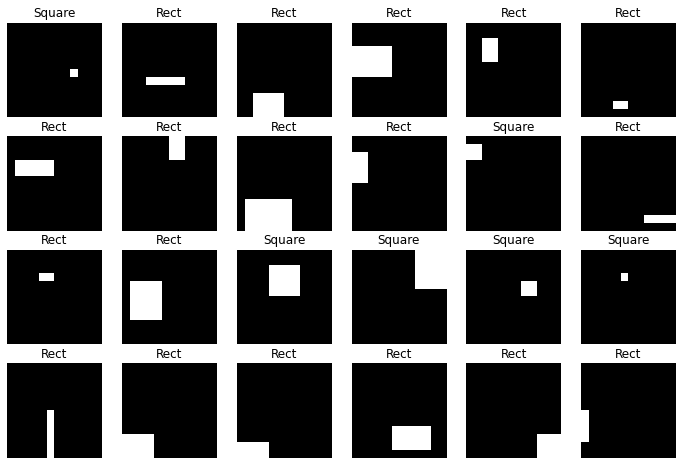

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i, (image, label) in enumerate(train_dataset):
    if i == 24: break
    plt.subplot(4, 6, i+1)
    plt.imshow(image[0], cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.title('Square' if label else 'Rect')
plt.show()

The CNN for this task is implemented below - note that as we're doing *binary* classification (between two classes), we output a single value. A value nearer to `0` is a prediction of class `0` and a value nearer to `1` is a predictions of class `1`.

In [ ]:
import torch.nn as nn

# This Printer class is just used to print out the shape of the tensor before
# putting it into the linear layer so we know what is the input size for the linear
# layer.
class Printer(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

class ConvNet(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(1, 2, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(4, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(4, 4, 3, padding=1),
            nn.ReLU(),
            # Printer(),
            nn.Flatten(),
            nn.Linear(36, 1)
        )
        self.to(device)

    def forward(self, x):
        return self.seq(x)

This function plots training and testing values (we'll use it to graph the loss and accuracy).

In [ ]:
def plot(title, train_vals, test_vals):
    plt.plot(range(len(train_vals)), train_vals, label='Train')
    plt.plot(range(len(test_vals)), test_vals, label='Test')
    plt.legend()
    plt.title(title)
    plt.show()

In [ ]:
def compute_accuracy(predictions, targets):
    # We will use a threshold of 0.5 to decide that the prediction is a square.
    # In practice sometimes it is good to change this threshold.
    predictions = torch.where(predictions >=0.5, 1, 0)
    # Count the number of predictions that match the target
    correct = (predictions == targets).sum().item()
    # Compute the accuracy as the percentage correctly predicted
    return correct / len(targets)

Here we have a function to perform training and testing.

In [ ]:
from tqdm.notebook import tqdm

def train_and_test(model, train_loader, test_loader, loss_func, optimiser, num_epochs, acc_func=None):
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    for epoch in tqdm(range(num_epochs)):
        sum_loss, sum_acc = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimiser.step()
            sum_loss += loss.item()
            if acc_func: sum_acc += acc_func(outputs, labels)
        train_losses.append(sum_loss / len(train_loader))
        train_accs.append(sum_acc / len(train_loader))

        sum_loss, sum_acc = 0, 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            sum_loss += loss.item()
            if acc_func: sum_acc += acc_func(outputs, labels)
        test_losses.append(sum_loss / len(test_loader))
        test_accs.append(sum_acc / len(test_loader))

    return train_losses, test_losses, train_accs, test_accs

### Train the Model

We now call the training and plotting functions to train and view the training and testing accuracy curves.

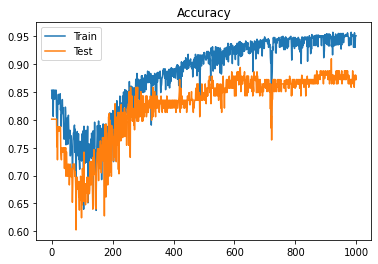

train loss:  0.2089490532875061
train accuracy:  0.9510416666666667
test loss:  7.693171739578247
test accuracy:  0.8723958333333333


In [ ]:
torch.manual_seed(42)

model = ConvNet(device)
# Note this Binary Cross Entropy Loss expects the input to be logits.
# This means you should not have a sigmoid at the end your model, since
# the sigmoid is automatically put there for you.
loss_func = nn.BCEWithLogitsLoss()

# Solution
loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(7))


# TODO: First try the code. Then adjust the learning rate (lr) to something more reasonable like 1e-3.
optimiser = torch.optim.Adam(model.parameters(), lr=1)
# SOLUTION LINE
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, test_losses, train_accs, test_accs = train_and_test(model,
                                                  train_loader,
                                                  test_loader,
                                                  loss_func,
                                                  optimiser,
                                                  num_epochs= 1000,
                                                  acc_func=compute_accuracy)

plot("Accuracy", train_accs, test_accs)

print("train loss: ", train_losses[-1])
print("train accuracy: ", train_accs[-1])
print("test loss: ", test_losses[-1])
print("test accuracy: ", test_accs[-1])


### Fix the Problem

That train acurracy is very unstable! Also the test accuracy just stays flat  This sort of accuracy curve is usually indicative of a badly-selected learning rate. The learning rate above is set to `1`, which would be considered a very high learning rate.


<font color='red'>Adjust the learning rate and train the model again. Try something smaller like 1e-3.</font>

### Detecting the class imbalance problem

The test accuracy looks weird, it starts at 80% and then only moves to around 85%. Lets now look a bit further under the hood. By looking at the distribution of rectangle and square examples in the train and test sets.

In [ ]:
train_square_proportion = len(torch.nonzero(train_dataset.labels)) / len(train_dataset.labels)
train_rect_proportion = 1 - train_square_proportion


test_square_proportion = len(torch.nonzero(test_dataset.labels)) / len(test_dataset.labels)
test_rect_proportion = 1 - test_square_proportion

print("Train data - Rectangle proportion:", "{:.3f}".format(train_rect_proportion), "Square proportion:", "{:.3f}".format(1- train_rect_proportion))
print("Test data - Rectangle proportion:", "{:.3f}".format(test_rect_proportion), "Square proportion:", "{:.3f}".format(1- test_rect_proportion))


Train data - Rectangle proportion: 0.843 Square proportion: 0.157
Test data - Rectangle proportion: 0.800 Square proportion: 0.200


It turns out the reason the model initially got 80% accuracy was because it just always predicted rectangle no matter what input it got. Since there was 80% rectangles in the test set it got the answer correct 80% of the time. Later the model was able to sometimes predict Squares but still not often enough hence it did not move much higher than 80%. There are so many more examples of rectangles compared to squares so during backprop most of the gradients try to steer the model towards predicting rectangles. 

Lets take a look at the confusion matrix on the trained model to confirm our intuition that the model is predicting too many rectangles instead of squares.

The first cell below contains the implementation of function used draw the confusion matrix which I copied from a file called plotcm.py from scikit-learn.org.

The second cell contains the code that uses the plot_confusion_matrix function defined in the previous cell to draw our confusion matrix.

Confusion matrix function definition

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Our code to draw the confusion matrix of our model results

Confusion matrix, without normalization
[[75  5]
 [ 9 11]]


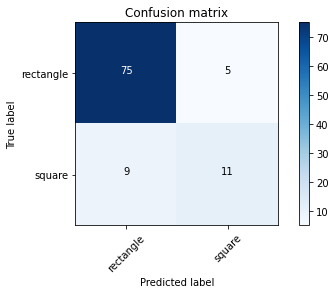

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix


# Gather targets and predictions for the whole test set
targets, predictions = [], []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    targets.extend(labels.detach().cpu().numpy())
    predictions.extend(outputs.detach().cpu().numpy())
targets = np.reshape(targets, -1).astype(int)
predictions = np.reshape(predictions, -1)
# we assign any prediction above or equal to 0.5 as 1 for square.
predictions = np.where(predictions >= 0.5, 1, 0)
cm = confusion_matrix(targets, predictions)
plot_confusion_matrix(cm, ["rectangle", "square"])

The bottom left and top right cells are where the predictions are different from the true labels. This result looks not too bad. It seems we are making a bit more mistakes predictions when the ground truth is squares (bottom left cell) than when the ground truth is rectangles (top right cell). But the problem looks much more obvious when we look at the next cell where we plot the normalized confusion matrix. 

Normalized confusion matrix
[[0.9375 0.0625]
 [0.45   0.55  ]]


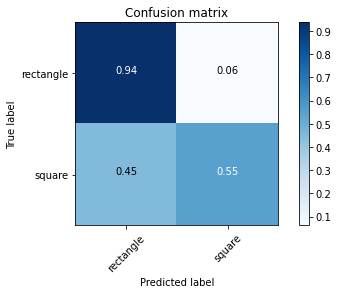

In [ ]:
# In this cell we will draw the normalized confusion matrix
plot_confusion_matrix(cm, ["rectangle", "square"], normalize = True)


<font color=red> This result shows us a really big problem! </font> Look at the bottom left cell. It says that we wrongly predicted about 65% (you may get something between 50% to 75%) of the images that contained squares. So this really shows us our result is actually much worse than the around 85% accuracy reported earlier. We need to use a different metric that better reflects our true performance in terms of both predicting rectangles and squares. So a fairer metric that treats rectangles and squares equally.

So lets turn to the unweighted average recall (UAR) metric which we discussed in lecture 4 to help us out. The UAR metric essentially assigns equal importance to correctly predicting rectangles and squares when they are present in the image. 

The next cell computes the UAR performance of our model on the test set.




In [ ]:
import numpy as np
from sklearn.metrics import recall_score

# Gather targets and predictions for the whole test set
targets, predictions = [], []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    targets.extend(labels.detach().cpu().numpy())
    predictions.extend(outputs.detach().cpu().numpy())
targets = np.reshape(targets, -1).astype(int)
predictions = np.reshape(predictions, -1)
# we assign any prediction above or equal to 0.5 as 1 for square.
predictions = np.where(predictions >= 0.5, 1, 0)

recall_rect = recall_score(targets, predictions, average='binary', pos_label=0)
print("recall for rectangles = ", recall_rect)
recall_square = recall_score(targets, predictions, average='binary', pos_label=1)
print("recall for squares = ", recall_square)
UAR = (recall_rect + recall_square) / 2
print("UAR = ", UAR)


recall for rectangles =  0.9375
recall for squares =  0.55
UAR =  0.74375


Notice the recall for squares is much lower than the recall for the rectangles. The UAR (the average of the two recalls) is about 0.66 (the number you get maybe different should be mostly similar). Lets try some techniques to help balance the training.

### Fix the Problem

Now that we have a method for truly measuring the model's performance, we should fix the class imbalance.

The simplest technique for correcting this is to change the proportion of examples that we present to the model. If we randomly select examples without any consideration for the imbalance, we will show the model 80% rectangles and 20% squares on average - we would like to instead show it 50% of each.

PyTorch provides a class [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) to help us with this. Instead of giving each example the same chance of being selected from the dataset, we can weight their selection probability - so an example with a weight of `2` is twice as likely to be selected as an example with a weight of `1`.

To undo the imbalance, we choose the weights based on the proportion of examples. So if classes `A` and `B` have a 9:1 ratio in a dataset, we would need to weight class `A` by a factor of 1, and class `B` by a factor of 9.

To compute this directly, the weights of a class should be $1 - p$, where $p$ is the proportion of that class in the dataset. We have already computed the proportions for each of our two classes, so we can use this equation to compute their appropriate weights.

<font color='red'>In the next cell, compute the sampling weights for the two classes.</font>

In [ ]:
# TODO: Compute the square and rectangle weights using the above equation
# square_weight = ...
# SOLUTION LINE
square_weight = 1 - train_square_proportion
# rect_weight = ...
# SOLUTION LINE
rect_weight = 1 - train_rect_proportion

The [WeightedRandomSampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.WeightedRandomSampler) class requires a weight for each example in the dataset, so we will iterate over every label in the training dataset and build a list of the correct weight. Run the next cell to do so.

In [ ]:

weights = [square_weight if l == 1 else rect_weight for l in train_dataset.labels]

# Print out the first 5 weights
print(weights[:5])

[0.8433333333333333, 0.15666666666666673, 0.15666666666666673, 0.15666666666666673, 0.15666666666666673]


All that's left now is to initialise the sampler and use it to create a new train dataloader.

In the next cell, initialise a <font color='red'>torch.utils.data.sampler.WeightedRandomSampler</font> by providing the weights list and the length of the train dataset as arguments.

If you code is correct the number of squares should be roughly half of the number of examples in the training set.

In [ ]:
# TODO: Initialise a WeightedRandomSampler
# sampler = ...
# SOLUTION LINE
sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(train_dataset))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)

total = 0
for inputs, labels in train_loader:
  total = total + labels.detach().cpu().numpy().sum()

print("number of squares: ", total)
print("total number of training examples:", len(train_dataset))


number of squares:  457.0
total number of training examples: 900


Once you've completed the above cell, return to the "Train the Model" section to try it out.

Once training has completed, run the cell that computes the UAR. If all goes well, the square recall should and the UAR should be higher than before as well. This is because we are showing the model balanced porportions of squares and rectangles throughout training. However, don't be too stressed it the square recall and UAR does not go higher. We have noticed there is some randomness in the results due to the small number of different square examples used during training. You may need to run again to see the benefits. The majority of the times when you rerun the training with the balanced sampler the results should be better. But you might get unlucky once or twice.

Although this method is very useful for handling class imbalance, it can't perform magic - there is a limit to its efficacy. So your UAR will still not be that high. There are other ways to handle skewed distributions. 



## Use a weighted Loss Function to Address Skew

There is another way to address skewed training distributions. We can increase the size of the gradients going back when training examples of the minority class. This way we can train in a more balanced way without the need to adjust the sampling rate of the two classes. 

It turns out the loss that we are currently using called <font color= red> torch.nn.BCEWithLogitsLoss</font> already has a parameter called <font color= red>pos_weight</font> that we can use to adjust the weighting we assign to the positive class (the class with label 1).

Take a look at this documentation to work out how you can modify the loss so the minor class gets more weight :
https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html

It is up to you to decide what weight to use and how to code it. Good luck! You should be able to get better results than using the balanced sampling method.
Please note you need to go back to the old standard dataloader, not the one you modified to use the balanced sampler. So please execute the code in the next cell to reset the dataloader for the training set to the old dataloader.


In [ ]:
# Run this code to reset the dataloader so we do not use the weighted sampler
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

## Challenge

As a challenge try to change the model, learning rate, optimization algorithms, increase the number of training epochs, play around with the loss weight, etc. to see if you can improve the UAR score, and let us know the best UAR you can get! Note that due to the small number of square training examples, you might find a lot of random fluctuation in your test accuracy which makes optimization very hard, so don't spend too much time on this. This is a really important habit to form since people tend to forget what they tried after some time.

You can also play around and see if you can optimize the accuracy of the forest cover classification problem as well. This is a much larger dataset and so produces more stable results. Also for fun you might want to see if the class distribution of this dataset is also imbalanced. If so, you want to do something about that too!

Good luck! By the end of this lab you will have practiced optimizing many different neural network models across the last few labs! You are starting to turn into a neural network optimizer pro!

Hopefully you've learnt something about debugging neural networks. Although there are many ways in which a neural network can fail, we've now seen three of the most common problems.